In [1]:
%load_ext autoreload
%autoreload 2
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl
%env PYOPENGL_PLATFORM=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco as mj
  from mujoco import mjx
  mj.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import numpy as np
import jax.numpy as jp
from scipy.signal import convolve2d
import mediapy as media
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Printing.
np.set_printoptions(precision=3, suppress=True, linewidth=100)
import pygments

from IPython.display import clear_output, HTML, display
clear_output()

print_style = 'lovelace'

def print_xml(xml_string):
  formatter = pygments.formatters.HtmlFormatter(style=print_style)
  lexer = pygments.lexers.XmlLexer() 
  highlighted = pygments.highlight(xml_string, lexer, formatter)
  display(HTML(f"<style>{formatter.get_style_defs()}</style>{highlighted}"))

def render(model, data=None, height=300, camera=-1):
  if data is None:
    data = mj.MjData(model)
  with mj.Renderer(model, 480, 640) as renderer:
    mj.mj_forward(model, data)
    renderer.update_scene(data, camera=camera)
    media.show_image(renderer.render(), height=height)

In [18]:
import jax
from vnl_playground.tasks.rodent.maze_forage import MazeForage

Converting to torque actuators


""

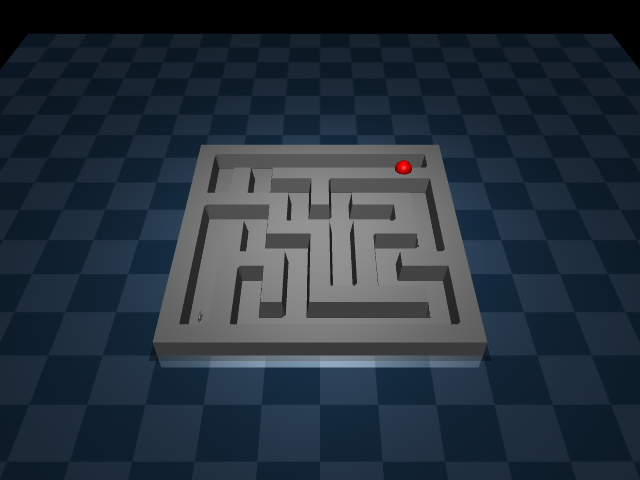

""

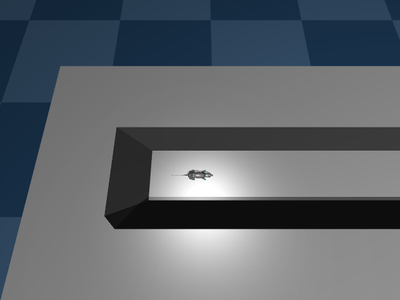

In [19]:
env = MazeForage()
render(env.mj_model, height=800)
render(env.mj_model, camera="top-rodent")

In [46]:
data = mj.MjData(env.mj_model)
data = mjx.put_data(env.mj_model, data)
torso_mat = data.bind(env.mjx_model, env._spec.body(f"torso{env._suffix}")).xmat
agent_pos = data.bind(env.mjx_model, env._spec.body(f"torso{env._suffix}")).xpos[:2]
agent_pos = jp.array(agent_pos)
forward_vec = jp.array(torso_mat[0, :2])
ray_lengths = env._raycast_lengths(agent_pos, forward_vec)
ray_lengths

[-1.571 -1.361 -1.152 -0.942 -0.733 -0.524 -0.314 -0.105  0.105  0.314  0.524  0.733  0.942  1.152
  1.361  1.571]


Array([0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015,
       0.015, 0.015, 0.015], dtype=float32, weak_type=True)

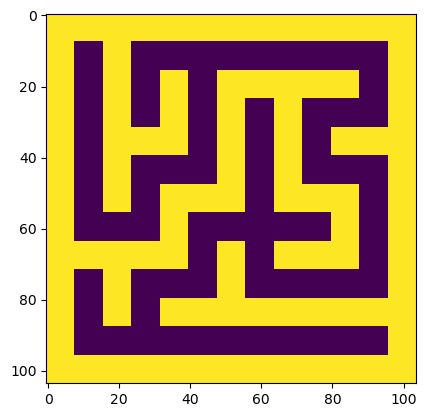

In [26]:
import matplotlib.pyplot as plt

plt.imshow(env._maze_array)

[-0.785 -0.576 -0.367 -0.157  0.052  0.262  0.471  0.681  0.89   1.1    1.309  1.518  1.728  1.937
  2.147  2.356]


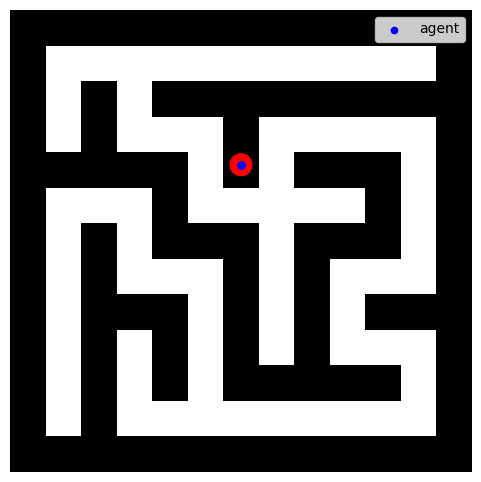

In [41]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_rays(env, x, y, angle):
    maze = np.array(env._maze_array)
    size = maze.shape[0]
    hsize = env._config.maze_hsize

    # world → pixel
    def world2pix(v):
        return (v + hsize) / (2 * hsize) * (size - 1)

    px = world2pix(x)
    py = world2pix(y)

    # get ray data
    forward = np.array([np.cos(angle), np.sin(angle)])
    dists = np.array(env._raycast_lengths(np.array([x, y]), forward))
    n_rays = env._config.vision_num_rays
    fov = env._config.vision_fov
    rels = np.linspace(-fov / 2, fov / 2, n_rays)
    angles = angle + rels

    # endpoints in pixel coords
    xs = x + np.cos(angles) * dists
    ys = y + np.sin(angles) * dists
    pex = world2pix(xs)
    pey = world2pix(ys)

    # origins repeated
    pxs = np.full(n_rays, px)
    pys = np.full(n_rays, py)
    dx = pex - pxs
    dy = pey - pys

    plt.figure(figsize=(6, 6))
    plt.imshow(maze, origin="lower", cmap="gray_r")
    plt.quiver(
        pxs,
        pys,
        dx,
        dy,
        angles="xy",
        scale_units="xy",
        scale=1,
        width=0.05,
        color="red",
    )
    plt.scatter(pxs, pys, c="blue", s=20, label="agent")
    plt.legend(loc="upper right")
    plt.axis("off")
    plt.show()


# Choose a world‐space point and heading:
x, y = -0.0, 1.0
heading = np.pi / 4  # 45° northeast

visualize_rays(env, x, y, heading)

In [ ]:
env._spec.worldbody

In [ ]:
reset_state = env.reset(jax.random.PRNGKey(0))

In [ ]:
step_state = env.step(reset_state, jp.zeros(env.action_size))

In [ ]:
reset_state.reward, step_state.reward

In [ ]:
# Generate Perlin noise
size = 128
noise = perlin((size, size), (8, 8)) * 2

# Remap noise to 0 to 1
noise = (noise + 1) / 2

# Makes the edges slope down to avoid sharp boundary
# noise *= edge_slope(size)

# Generate a two-dimensional Gaussian for the bowl effect.
# Create a grid of (x, y) coordinates ranging from -1 to 1.
y = np.linspace(-1, 1, noise.shape[0])
x = np.linspace(-1, 1, noise.shape[1])
xv, yv = np.meshgrid(x, y)

# Parameters for the Gaussian bowl.
# Use a negative amplitude to create a depression (bowl shape).
sigma = 0.5  # Controls the width of the Gaussian
amplitude = -10.0  # Controls the depth; negative value makes a bowl-like dip
gaussian_bowl = amplitude * np.exp(-(xv**2 + yv**2) / (2 * sigma**2))

# Add the Gaussian bowl to the Perlin noise height field.
noise = noise + gaussian_bowl

noise -= np.min(noise)
noise /= np.max(noise)

In [ ]:
def interp_height(
    noise: jp.ndarray, x: float, y: float, hsize: float, elevation_z: float
) -> float:
    nrow, ncol = noise.shape

    # map to fractional indices
    u = (x + hsize) / (2 * hsize) * (ncol - 1)
    v = (y + hsize) / (2 * hsize) * (nrow - 1)
    i0 = jp.clip(jp.floor(v).astype(int), 0, nrow - 2)
    j0 = jp.clip(jp.floor(u).astype(int), 0, ncol - 2)
    di = v - i0
    dj = u - j0

    # four corners
    h00 = noise[i0, j0]
    h10 = noise[i0, j0 + 1]
    h01 = noise[i0 + 1, j0]
    h11 = noise[i0 + 1, j0 + 1]

    # interpolate
    h0 = h00 * (1 - dj) + h10 * dj
    h1 = h01 * (1 - dj) + h11 * dj
    h_norm = h0 * (1 - di) + h1 * di

    # scale by elevation_z
    return h_norm * elevation_z


interp_height(noise, 0, 0, 2, 1)

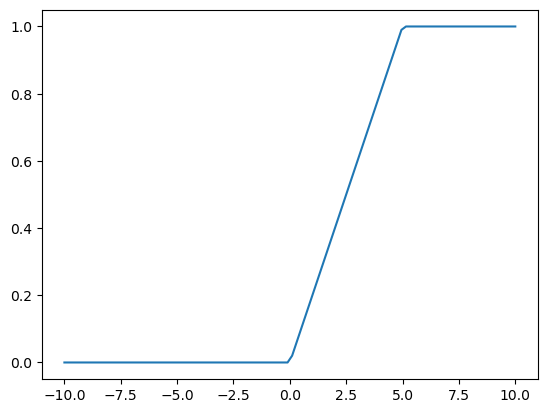

In [2]:
from mujoco_playground._src import reward
import numpy as np
import matplotlib.pyplot as plt

space = np.linspace(-10, 10, 100)
r = reward.tolerance(
    space,
    bounds=(5, float("inf")),
    margin=5,
    value_at_margin=0,
    sigmoid="linear",
)
plt.plot(space, r)